# Open Analytics Framework

- OAF (Open Analytics Framework) は Teradata VantageCloud Lake で利用可能な機能です
- クラウド上のクラスタ（サーバー）に自由な分析環境（主にPython, R）を構築し、自由なスクリプトを実行することができます
- スクリプトはデータベース上のデータと連携することが可能となるため、データ移動を最小限に抑えつつ、柔軟な分析実装を実現します

＊ ClearScape Experience はこの機能をサポートしないため、このノートブックは実行できません
  これは別環境で実行した例です。参考用としてご覧ください。

Password >  ········


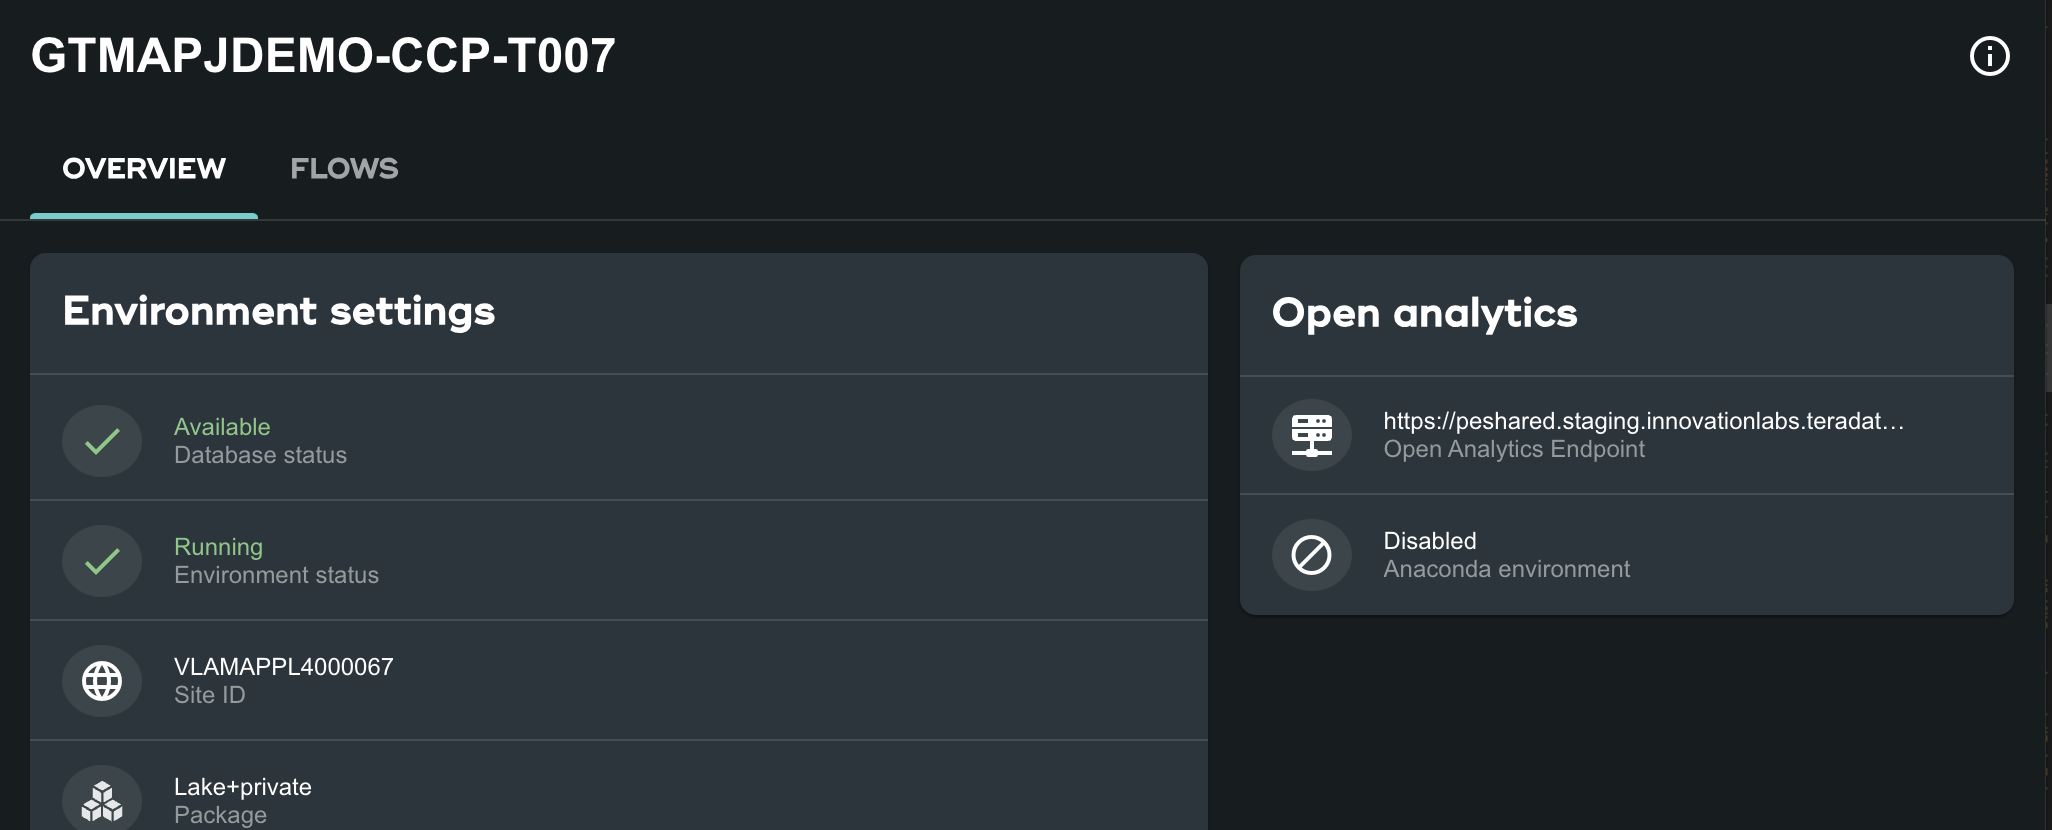

In [1]:
# Set the database information
# If you don't know yours, ask your DBA!

from urllib.parse import quote_plus
from IPython.display import Image
from getpass import getpass

# database connection info
host = input("Host IP > ")
user = input("User > ")
database = input("Default database >")
password = getpass("Password > ")
encryptdata = "true"
dbs_port = 1025

connstr = (
    f"teradatasql://{user}:{quote_plus(password)}@{host}/"
    f"?dbs_port={dbs_port}"
    f"&encryptdata={encryptdata}"
    f"&database={database}"
)

# analytic compute cluster info
compute_group = input("Compute Group >")

# Endpoint of analytic compute cluster
# Find the endpoint URL from the Cloud Lake console
ues_url = input("UES URL > ")
client_id = input("Client ID > ")

# Cluster environment name
envname = "my_env_basic"

In [2]:
# Create teradataml context

from sqlalchemy import create_engine
from teradataml import create_context, remove_context
engine = create_engine(connstr)
context = create_context(tdsqlengine=engine, temp_database_name=database)

# and test the context
from teradataml import get_connection
import pandas as pd
x = pd.read_sql("SELECT SESSION, CURRENT_TIMESTAMP", get_connection())
x

,Session,Current TimeStamp(6)
0,780398,2024-03-19 12:57:06.470000+00:00


In [3]:
# To simplify the command to run queries, let's define a magic command `%td`
from IPython.core.magic import register_line_magic

@register_line_magic
def td(*query, maxrows=10000):
    from datetime import datetime
    from teradataml import get_connection
    import pandas as pd
    import sys
    t1 = datetime.now()
    conn = get_connection()
    print(f"Start query at {t1}", file=sys.stderr)
    for q in query[:-1]:
        conn.execute(q)
    for df in pd.read_sql(query[-1], conn, chunksize=maxrows):
        break
    t2 = datetime.now()
    print(f"End query at {t2}, elapsed: {t2-t1}", file=sys.stderr)
    return df
del td

# test it
%td SELECT SESSION, CURRENT_TIMESTAMP

Start query at 2024-03-19 21:57:06.298893
End query at 2024-03-19 21:57:06.840537, elapsed: 0:00:00.541644


,Session,Current TimeStamp(6)
0,780398,2024-03-19 12:57:07.030000+00:00


In [4]:
# Set the compute group to use during the session

%td SET SESSION COMPUTE GROUP {compute_group}

Start query at 2024-03-19 21:57:06.851846
End query at 2024-03-19 21:57:07.454804, elapsed: 0:00:00.602958


""


In [5]:
# Confirm that compute cluter is running
%td SELECT * FROM dbc.ComputeProfilesV

Start query at 2024-03-19 21:57:07.463223
End query at 2024-03-19 21:57:08.067099, elapsed: 0:00:00.603876


,ComputeProfileName,ComputeProfileUniqName,ComputeGroupName,ComputeMapName,InstanceType,ComputeCount,ComputeProfileState,ComputeProfilePolicy,CreatorName,CommentString,CreateTimeStamp,LastAlterUserName,LastAlterTimeStamp
0,CP_BusGrpA_STD_2_XSM,computeprofile1,CG_BUSGRPA_STD,TD_COMPUTE_XSMALL,STANDARD,0,Suspended,"{""MIN_COMPUTE_COUNT"":1,""MAX_COMPUTE_COUNT"":2,""...",cgadmin,None,2024-03-04 13:46:22,TDaaS_CloudMonitor1,2024-03-04 14:39:50
1,CP_BusGrpA_ANL_1_SML,computeprofile2,CG_BUSGRPA_ANL,TD_COMPUTE_SMALL,ANALYTIC,1,Running,"{""MIN_COMPUTE_COUNT"":1,""MAX_COMPUTE_COUNT"":1,""...",cgadmin,None,2024-03-04 13:46:23,TDaaS_CloudMonitor1,2024-03-19 07:30:39
2,PF_1,computeprofile3,CG_DEMOMR_1,TD_COMPUTE_XSMALL,STANDARD,0,Suspended,"{""MIN_COMPUTE_COUNT"":1,""MAX_COMPUTE_COUNT"":1,""...",DBC,None,2024-03-07 19:44:35,TDaaS_CloudMonitor1,2024-03-08 19:19:25


In [6]:
# Configure base URL to the specific account service

from teradataml import set_auth_token

if set_auth_token(ues_url=ues_url, client_id=client_id):
    print("UES Authentication successful")
else:
    print("UES Authentication failed, check URL and account info")

Opening the browser with URL - https://tddemos.innovationlabs.teradata.com/auth/as/user_authz.oauth2?user_code=JGX7-PJ74

Opened a session in browser. Authenticate yourself in the browser. In case if not able to access the opened session in browser, Open a session in any browser on any machine using URL - https://tddemos.innovationlabs.teradata.com/auth/as/user_authz.oauth2?user_code=JGX7-PJ74
UES Authentication successful


In [7]:
# Create cluster environment
from teradataml import list_base_envs, list_user_envs
display(list_base_envs())
display(list_user_envs())

,base_name,language,version
0,python_3.8,Python,3.8.18
1,python_3.9,Python,3.9.18
2,python_3.10,Python,3.10.13
3,r_4.1,R,4.1.3
4,r_4.0,R,4.0.5
5,r_4.2,R,4.2.2


,env_name,env_description,base_env_name,language,conda
0,Creditsaison_Env,Demonstration dedicated python environment,python_3.10,Python,False
1,my_demo_detect,This env 'my_demo_detect' is created with base...,python_3.10,Python,False
2,my_demo_env,This env 'my_demo_env' is created with base en...,python_3.10,Python,False
3,my_demo_env2,This env 'my_demo_env2' is created with base e...,python_3.10,Python,False
4,my_env_basic,This env 'my_env_basic' is created with base e...,python_3.10,Python,False
5,my_env_detect,This env 'my_env_detect' is created with base ...,python_3.10,Python,False


In [8]:
from teradataml import get_env, create_env, remove_env

# Delete exiting env if exists,
try:
    env = get_env(envname)
except Exception as e:
    print(f"{e}", file=sys.stderr)
    # Create a new env
    env = create_env(envname)
env


Environment Name: my_env_basic
Base Environment: python_3.10
Description: This env 'my_env_basic' is created with base env 'python_3.10'.

############ Libraries installed in User Environment ############

              name      version
0            numpy       1.26.4
1           pandas        2.2.1
2              pip       23.0.1
3  python-dateutil  2.9.0.post0
4             pytz       2024.1
5       setuptools       65.5.0
6              six       1.16.0
7           tzdata       2024.1


In [9]:
# Install PyPI libraries needed by the script
# Using option asynchronous=True for an asychronous execution of the statement.
# Note: Avoid asynchronous installation when batch-executing all notebook statements,
#       as execution will continue even without installation being complete.
#
import time

claim_id = env.install_lib(["pandas"], asynchronous=True)
print(claim_id)

# Check the progress of the library instlation
print("Waiting..", end="")    
while True:
    status = env.status(claim_id)
    if "Finished" in status.Stage.tolist():
        print("Installation finished!")
        display(status)
        break
    print(".", end="")
    time.sleep(5)

env

Request to install libraries initiated successfully in the remote user environment my_env_basic. Check the status using status() with the claim id 'c29b0e16-9784-41b4-9eee-7086488f832c'.
c29b0e16-9784-41b4-9eee-7086488f832c
Waiting.......Installation finished!


,Claim Id,File/Libs/Model,Method Name,Stage,Timestamp,Additional Details
0,c29b0e16-9784-41b4-9eee-7086488f832c,pandas,install_lib,Started,2024-03-19T12:57:26Z,
1,c29b0e16-9784-41b4-9eee-7086488f832c,pandas,install_lib,Finished,2024-03-19T12:57:57Z,



Environment Name: my_env_basic
Base Environment: python_3.10
Description: This env 'my_env_basic' is created with base env 'python_3.10'.

############ Libraries installed in User Environment ############

              name      version
0            numpy       1.26.4
1           pandas        2.2.1
2              pip       23.0.1
3  python-dateutil  2.9.0.post0
4             pytz       2024.1
5       setuptools       65.5.0
6              six       1.16.0
7           tzdata       2024.1


In [10]:
# Basic: Run a simple shell command and understand how it works
from teradataml import Apply
from teradatasqlalchemy.types import BIGINT, VARCHAR, FLOAT, INTEGER

job = Apply(
    apply_command='echo "Hello, OAF!"',
    env_name=env,
    delimiter="\t",
    returns={"message": VARCHAR(30)}
)
result = job.execute_script()

result.to_pandas()

/Users/km255052/venv/sandbox/lib/python3.10/site-packages/teradataml/common/utils.py:661: VantageRuntimeWarning: [Teradata][teradataml](TDML_2086) Following warning raised from Vantage with warning code: 4854
[Teradata Database] [Warning 4854] Table 'ml__td_tblop_out__1710856207403051' is set to NO FALLBACK.
  warnings.warn(msg_.format(warnRes[5], warnRes[6]), VantageRuntimeWarning)


TeradataMlException: [Teradata][teradataml](TDML_2010) Failed to create Teradata DataFrame.

In [ ]:
# Basic: Run a simple python script and understand how it works
from teradataml import Apply
from teradatasqlalchemy.types import VARCHAR

script = """
print("Hello, Python with OAF!")
"""
with open("hello.py", "w") as f:
    f.write(script)

env.install_file('hello.py', replace=True)

# Show the list of files in the demo env
display(env.files)

# Now, run the script!
job = Apply(
    apply_command="python3 hello.py",
    env_name=env,
    delimiter="\t",
    returns={"message": VARCHAR(30)}
)
result = job.execute_script()

result.to_pandas()

In [ ]:
# Using data from OAF cluster

# Load data to the vantage
# THis is an example data of the daily temperature of several cities in Japan
x = pd.read_csv("temperature.csv")
x["date"] = pd.to_datetime(x["date"], format="%Y/%m/%d")
display(x)
display(x.groupby("location").mean(numeric_only=True))

# Confirm that the data has been successfully loaded
from teradataml import copy_to_sql, DataFrame
copy_to_sql(x, "temperature", if_exists="replace")
x = DataFrame("temperature")
x

In [ ]:
# Basic: Get the number of rows and columns
# 
# Note that data are randomly disributed across container instances here
from teradataml import Apply
from teradatasqlalchemy.types import INTEGER

script = r"""
import sys
import pandas as pd

columns = ["date", "location", "avg_temp", "max_temp"]
x = pd.read_csv(
    sys.stdin,
    sep="\t",
    header=None,
    names=columns
)

print(f"{x.shape[0]}\t{x.shape[1]}")
"""
with open("shape.py", "w") as f:
    f.write(script)

env.install_file('shape.py', replace=True)

# Show the list of files in the demo env
display(env.files)

# Now, run the script!
data = DataFrame("temperature")
job = Apply(
    apply_command="python3 shape.py",
    env_name=env,
    delimiter="\t",
    data=data,
    returns={"nrows": INTEGER(), "ncols": INTEGER()}
)
result = job.execute_script()

result.to_pandas()

In [ ]:
# Run the same script with partition
#
# Now data are distributed seperately by the locations
data = DataFrame("temperature")
job = Apply(
    apply_command="python3 shape.py",
    env_name=env,
    delimiter="\t",
    data=data,
    data_partition_column="location",
    returns={"nrows": INTEGER(), "ncols": INTEGER()}
)
result = job.execute_script()

result.to_pandas()

In [ ]:
# Run the same script with partition by day
#
# Now data are distributed seperately by the day
# We have 1523 rows, the number of days in the dataset.
# We have only 48 processes, but need to run the script for 1523 times.
# As a result, the command below takes longer time than the previous examples
data = DataFrame("temperature")
job = Apply(
    apply_command="python3 shape.py",
    env_name=env,
    delimiter="\t",
    data=data,
    data_partition_column="date",
    returns={"nrows": INTEGER(), "ncols": INTEGER()}
)
result = job.execute_script()

result.to_pandas()

In [ ]:
# Basic: Convert celsius to fahrenheit
from teradataml import Apply
from teradatasqlalchemy.types import VARCHAR, TIMESTAMP, FLOAT

script = """
import sys
import pandas as pd

columns = ["date", "location", "avg_temp", "max_temp"]
x = pd.read_csv(
    sys.stdin,
    sep="\t",
    header=None,
    names=columns
)
if len(x) == 0:
   sys.exit()

# 気温を 摂氏から華氏に変換
x["avg_temp_f"] = x["avg_temp"] * 9/5 + 32
x["max_temp_f"] = x["max_temp"] * 9/5 + 32

out = x[["date", "location", "avg_temp", "avg_temp_f", "max_temp", "max_temp_f"]]
# 結果は標準出力へTSV形式で与える
out.to_csv(sys.stdout, sep="\t", index=False, header=False)
"""

with open("convert.py", "w", encoding="utf8") as f:
    f.write(script)
    
env.install_file('convert.py', replace=True)

# Show the list of files in the demo env
display(env.files)


data = DataFrame("temperature")
job = Apply(
    apply_command="python3 convert.py",
    env_name=env,
    delimiter="\t",
    data=data,
    returns={'"date"': TIMESTAMP(6), "location": VARCHAR(20),
             "avg_temp": FLOAT(), "avg_temp_f": FLOAT(),
             "max_temp": FLOAT(), "max_temp_f": FLOAT()}
)
result = job.execute_script()

print(result.shape)
result

In [ ]:
q = """
create multiset table data_scientist.test_ofs,no fallback
  ,map = td_map2
  ,STORAGE = TD_OFSSTORAGE
as (select 1 as x, 'abc' as y)
with data
no primary index
partition by column
"""
%td {q}

In [ ]:
# Basic: Confirm that OpenAF works with OFS table
from teradataml import Apply, DataFrame
from teradatasqlalchemy.types import VARCHAR, INTEGER, FLOAT

script = """
import sys
import pandas as pd

columns = ["x", "y"]
x = pd.read_csv(
    sys.stdin,
    sep="\t",
    header=None,
    names=columns
)
if len(x) == 0:
   sys.exit()

x["added"] = 3.14
# 結果は標準出力へTSV形式で与える
x.to_csv(sys.stdout, sep="\t", index=False, header=False)
"""

with open("test.py", "w", encoding="utf8") as f:
    f.write(script)
    
env.install_file('test.py', replace=True)

# Show the list of files in the demo env
display(env.files)


data = DataFrame("test_ofs")
job = Apply(
    apply_command="python3 test.py",
    env_name=env,
    delimiter="\t",
    data=data,
    returns={"x": INTEGER(), "y": VARCHAR(10), "added": FLOAT()}
)
result = job.execute_script()

print(result.shape)
result